<a id="intro"></a>
# Исследование объявлений о продаже квартир

**Описание проекта**

Заказчик — сервис Яндекс Недвижимость. 

Входные данные - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

Результаты исследования рыночной стоимости объектов недвижимости позволят построить автоматизированную систему для отслеживания аномалий и мошеннической деятельности.

По каждой квартире на продажу доступны два вида данных:
- **Первые** вписаны пользователем,
- **Вторые** — получены автоматически на основе картографических данных. Расстояние до центра, аэропорта и других объектов — автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цели исследования** - ответить на вопросы:
1. [В каких параметрах объектов недвижимости встречаются редкие и выбивающиеся значения](#data_analysis)
2. [Как быстро продавались квартиры](#how_fast)
3. [Какие факторы больше всего влияют на общую (полную) стоимость объекта](#factors)
4. [У каких населённых пунктов самая высокая и низкая стоимость квадратного метра](#localities)
5. [Как стоимость объектов зависит от расстояния до центра города](#center_distance)

 👉 **[Итоги исследования здесь](#research_results)**

**Описание данных**
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

## Общая информация о данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import os
import seaborn as sns

In [2]:
# чтение файла с данными и сохранение в data
pth1 = 'https://github.com/AlexSlobodskoj/Projects/blob/main/Real_estate/real_estate_data.csv'
pth2 = '/Users/alexslobodskoj/real_estate_data.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, sep='\t')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, sep='\t')
else:
    print('Something is wrong')

# преобразование научной нотации больших чисел для удобства
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# вывод первых 5 строчек датафрейма `data` на экран
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [4]:
# вывод основной информации о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

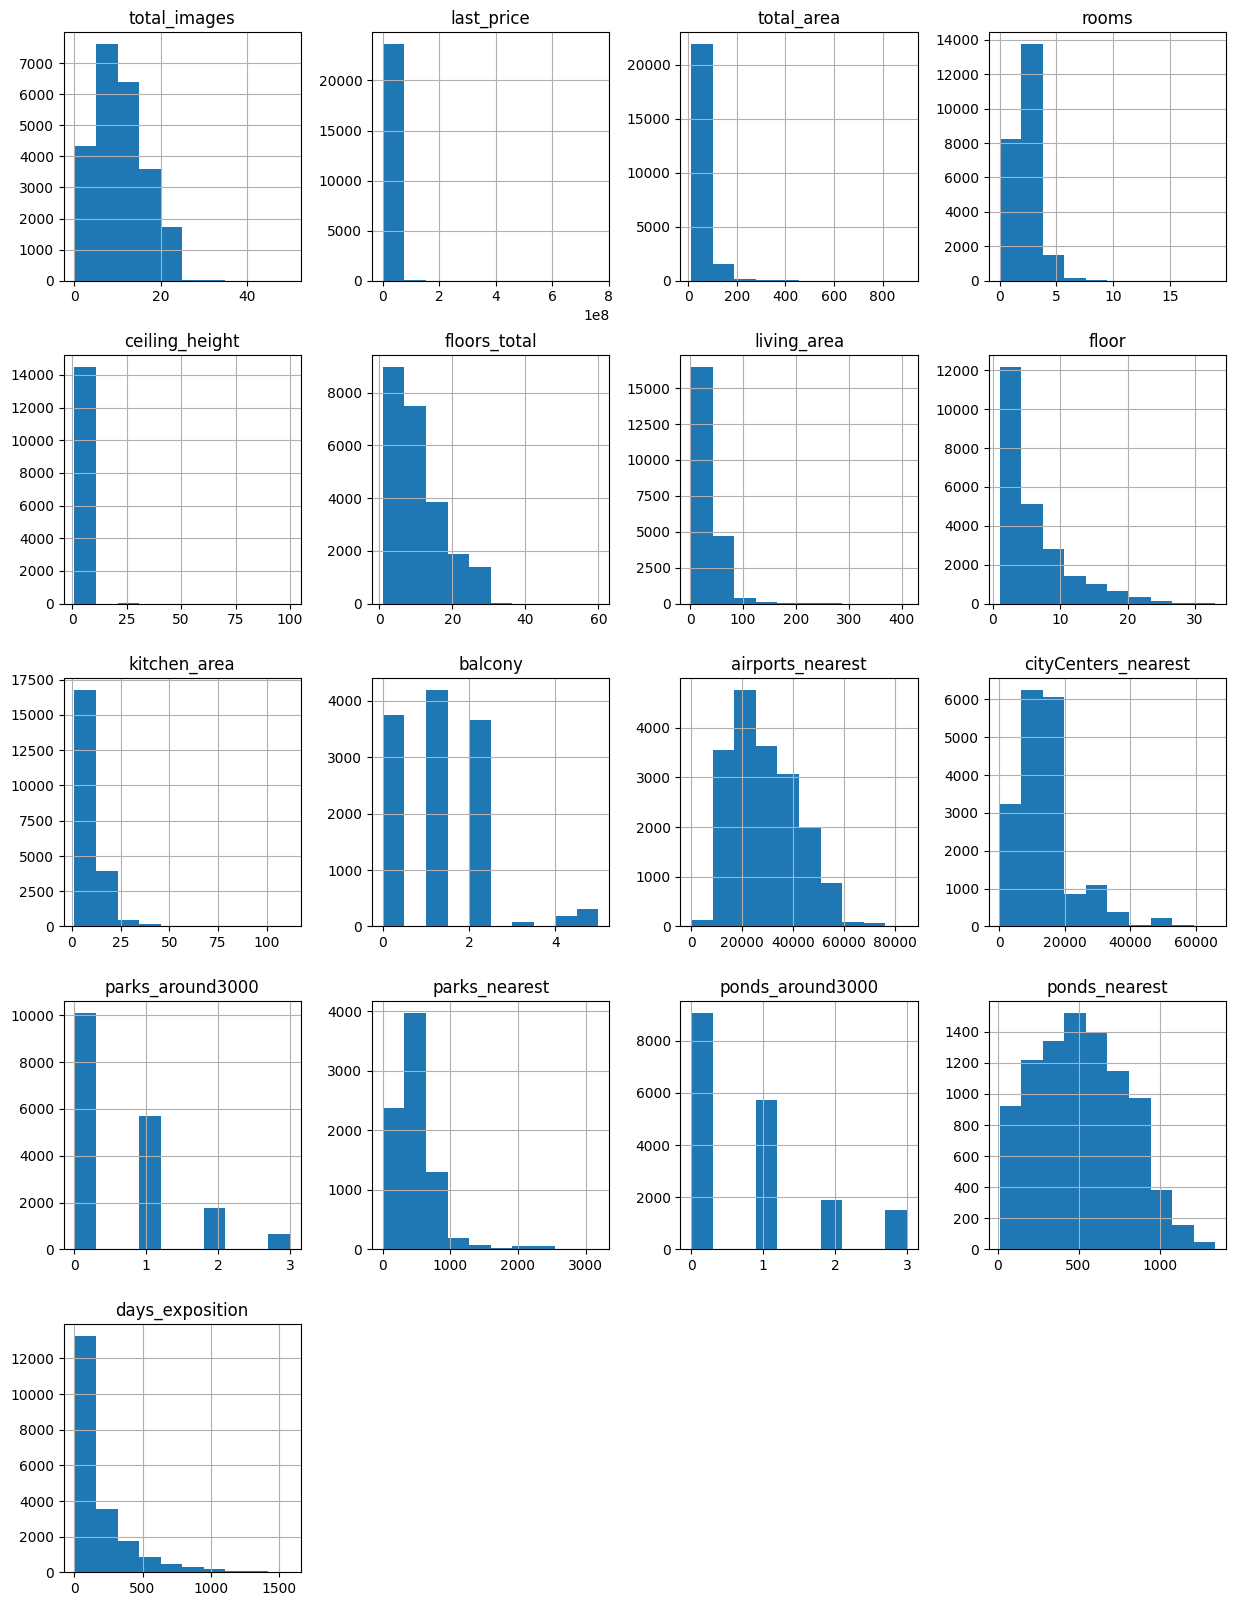

In [5]:
# гистограммы для всех числовых столбцов
data.hist(figsize=(15, 20))
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**
- есть неслучайные пропущенные значения из-за технических ошибок и человеческого фактора
- есть выбросы и аномальные значения
- в некоторых столбцах необходимо изменить тип данных

## Предобработка данных

### Удаление пропусков

Пропущенные значения обнаружены в следующих столбцах:

In [6]:
# вывод названий столбцов с пропусками и количества пропусков
data.isna().sum()[data.isna().sum() > 0]

ceiling_height          9195
floors_total              86
living_area             1903
is_apartment           20924
kitchen_area            2278
balcony                11519
locality_name             49
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
parks_nearest          15620
ponds_around3000        5518
ponds_nearest          14589
days_exposition         3181
dtype: int64

Рассчитаем долю пропущенных значений.

In [7]:
(
    pd.DataFrame(data.isna().mean()*100)
    .style.format("{:.1f}")
    .background_gradient('coolwarm')
)

,0
total_images,0.0
last_price,0.0
total_area,0.0
first_day_exposition,0.0
rooms,0.0
ceiling_height,38.8
floors_total,0.4
living_area,8.0
floor,0.0
is_apartment,88.3


В **11** столбцах есть пропущенные значения. Пропуски в: `ceiling_height` и `living_area` обработаем в [п.2.3](#dropna)

Заполним пропуски в четырех столбцах с пропущенными значениями:

- `is_apartment`
- `balcony`
- `floors_total`

В остальных столбцах с пропущенными значениями логичную замену предложить невозможно. Оставим их без изменения.


**Заполнение пропусков в столбце `is_apartment`** 

В столбце используется булево значение.
Очевидно:

- 1 - квартира является апартаментами
- 0 - не является
  
Предположительно, если признак апартаментов отсутствуют, то это означает, что объект не является апартаментами. Заполним пропущенный признак апартаментов.

In [8]:
# заполнение пропущенных значений в столбце `is_apartment` булевым `False` 
data['is_apartment'] = \
(
    data['is_apartment']
    .astype(bool)
    .fillna(False)
)

**Заполнение пропусков в столбце `balcony`** 

Предположим, если количество балконов не указано, то значит - балкона нет. Заполним числом "0" пропущенные значения количества балконов.

In [9]:
# заполнение пропущенных значений в столбце `balcony`
data['balcony'] = data['balcony'].fillna(0)

**Заполнение пропусков в столбце `floors_total`** 

Пропущенные значения этажности дома заполним информацией об этаже, на котором находится квартира.

In [10]:
# заполнеие пропусков в столбце `floors_total`
data['floors_total'] = data['floors_total'].fillna(data['floor'])

<div style="border:solid gray 1px; padding: 20px">

**Возможные причины** появления пропусков:
- **Человеческий фактор**: Ошибки при вводе данных или неправильное понимание инструкций по вводу данных
- **Технические ошибки**: Ошибки при сборе или обработке данных. Например, отсутствие автоматического контроля по заполнению категорийных данных

### Устранение неявных дубликатов

Оценим количество и уникальные значения названий населенных пунктов.

In [11]:
# вывод количества уникальных значений в столбце 'locality_name'
display(
    Markdown(
        f'Количество уникальных значений: '
        f'**{data["locality_name"].nunique()}**')
)

# вывод отсортированного уникального списка значений в 'locality_name'
(
    data['locality_name']
    .sort_values()
    .unique()
)    

Количество уникальных значений: **364**

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В столбце с названиями населённого пункта присутствуют неявные дубликаты и пропущенные значения. Устраним их для дальнейшего использования населенного пункта при заполнении пропущенных значений в столбце `ceiling_height`.

**Планируемые замены:**
- "ё" на "е"
- "при железнодорожной станции" на "станции"
- "городской поселок" и "поселок городского типа" на "поселок"
- пропущенные значения на "без населенного пункта"

Для сохранения оригинального названия населенного пункта - замененные названия запишем в новый столбец `locality_name_dupless`

In [12]:
# запись последовательных замен в новый столбец `locality_name_dupless`
data['locality_name_dupless'] = \
(
    data['locality_name']
    .str.replace('ё', 'е')
    .replace('при железнодорожной станции', 'станции', regex=True)
    .replace(['городской ', ' городского типа', ''], '', regex=True)
    .replace('коттеджный ', '', regex=True)
    .fillna('без н/п')
    .str.strip()
) 

# вывод количества уникальных значений в столбце 'locality_name'
display(
    Markdown(
        f'Количество уникальных значений: '
        f'**{data["locality_name_dupless"].nunique()}**')
)

Количество уникальных значений: **320**

После устранения неявных дубликатов количество населенных пунктов сократилось на **12%** - с 364 до 320

<a id="dropna"></a>
### Удаление пропусков (продолжение)

**Заполнение пропусков в столбце `ceiling_height`**

1. Заполним медианными значениями по каждому населенному пункту из столбца `locality_name_dupless`.
2. Есть населенные пункты у которых все значения в столбце `ceiling_height` пропущены. Информацию по ним заполним медианным значением по всему столбцу `ceiling_height`

In [13]:
# функция для заполнения пропущенных значений медианным значением
def fillna_median(x):
    if x.count() > 0:
        return x.fillna(x.median())
    else:
        return x

# заполнение пропусков в столбце ceiling_height медианными значениями 
# по населенному пункту из столбца `locality_name_dupless`        
data['ceiling_height'] = \
(
    data.groupby('locality_name_dupless')['ceiling_height']
    .transform(fillna_median)
)    
# заполнение оставшихся пропусков в столбце ceiling_height медианным значением столбца
data['ceiling_height'] = \
(
    data['ceiling_height']
    .fillna(data['ceiling_height'].median())
)

**Заполнение пропусков в столбце `living_area`**

1. Создадим столбец `ratio_area_living`как отношение медианных значений обшей площади и жилой площади по каждому населенному пункту из столбца `locality_name_dupless`.
2. Есть населенные пункты у которых нет значений жилой площади для расчета медианы и получения `ratio_area_living`. Значение `ratio_area_living` по ним заполним как отношение медианных значений столбцов обшей площади и жилой площади.
3. Заполним пропуски в жилой площади поделив значения общей площади на `ratio_area_living`

In [14]:
# запись в переменную `ratio_area` отношения медиан общей и жилой площади 
# по каждому населенному пункту
ratio_area = data.groupby('locality_name_dupless')[['total_area', 'living_area']].transform('median')

# преобразование `ratio_area` в датафрейм
ratio_area = pd.DataFrame(ratio_area['total_area'] / ratio_area['living_area'], columns=['ratio_area_living'])

# присоединение датафрейма `ratio_area` к датафрейму `data`
data = data.join(ratio_area)

# запись в столбец `ratio_area_living` отношения медиан столбцов общей и жилой площади
data['ratio_area_living'] = \
(
    data['ratio_area_living']
    .fillna(data['total_area'].median() / data['living_area'].median())
)    
# заполнение пропусков в `living_area`
data['living_area'] = \
(
    data['living_area']
    .fillna(data['total_area'] / data['ratio_area_living'])
)

### Изменение типов данных

В следущих столбцах необходимо изменить тип данных:

- `first_day_exposition` с текстового на DateTime для дальнейшего использования дня, месяца, года
- `floors_total` c float64 на int64 - количество этажей в доме не может быть дробным числом
- `balcony` c float64 на int64 - количество балконов не может быть дробным числом
- `days_exposition` c float64 на int64 - количество дней размещения объявления не может быть дробным числом

In [15]:
# изменение типа данных в столбцах 'floors_total', 'balcony'
data[['floors_total', 'balcony']] = \
(
    data[['floors_total', 'balcony']]
    .astype('int64', errors='raise')
)   

# изменение типа данных в столбце 'days_exposition'
data['days_exposition'] = \
(
    data['days_exposition']
    .round()
    .astype(pd.Int64Dtype())
)

# изменение типа данных в столбце `first_day_exposition`
data['first_day_exposition'] = \
pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим результаты преобразования типов данных

In [16]:
# проверка изменения типов данных
data[['floors_total', 'balcony', 'days_exposition','first_day_exposition']].dtypes

floors_total                     int64
balcony                          int64
days_exposition                  Int64
first_day_exposition    datetime64[ns]
dtype: object

## Добавление новых столбцов

**Цена квадратного метра**

Добавим в стобец `price_meter` цену одного квадратного метра. Поделим стоимость на момент снятия с публикации из столбца `last_price` на общую площадь квартиры в квадратных метрах `total_area` и округлим до двух знаков после запятой.

In [17]:
# добавление столбца 'price_meter' с ценой квадратного метра
data['price_meter'] = round(data['last_price'] / data['total_area'], 2)

**День недели**

Добавим в стобец `day_public`день недели публикации объявления. Получим день из информации о дате публикации в столбце `first_day_exposition`. Используем специальный атрибут `dt`.

In [18]:
# добавление столбца `day_puplc`
data['day_public'] = data['first_day_exposition'].dt.weekday

**Месяц публикации**

Добавим в стобец `month_public`месяц в который было опубликовано объявление. Получим месяц из информации о дате публикации в столбце `first_day_exposition`. Используем специальный атрибут `dt`.

In [19]:
# добавление столбца `month_puplc`
data['month_public'] = data['first_day_exposition'].dt.month

**Год публикации**

Добавим в стобец `year_public`год в который было опубликовано объявление. Получим год из информации о дате публикации в столбце `first_day_exposition`. Используем специальный атрибут `dt`.

In [20]:
# добавление столбца `year_puplc`
data['year_public'] = data['first_day_exposition'].dt.year

**Тип этажа квартиры**

Добавим в стобец `floor_type`тип этажа квартиры в зависимости от этажа квартиры в столбце `floor` и этажности дома в столбце `floors_total`:

- "первый", если квартира на первом этаже
- "последний", если этаж квартиры совпадает с этажностью дома
- "другой" - во всех остальных случаях

In [21]:
# добавление столбца `floor_type` из `floor`
# для `floor` = 1 в `floor_type` запишется 'первый'
# для `floor` = 'floors_total' в `floor_type` запишется 'последний'
# в остальных случаях в `floor_type` запишется 'другой'
data['floor_type'] = \
(
    data['floor']
    .where(data['floor'] != 1, 'первый')
    .where(data['floor'] != data['floors_total'], 'последний')
    .where((data['floor'] == 1) | (data['floor'] == data['floors_total']), 'другой')
)

**Расстояние до центра города**

Добавим в стобец `cityCenters_km`расстояние до центра города в километрах. Пересчитаем расстояние из столбца `cityCenters_nearest` и округлим до ближайшего целого.

In [22]:
# добавление столбца `cityCenters_km`
data['cityCenters_km'] = \
(
    data.query('cityCenters_nearest.notna()')
    ['cityCenters_nearest'] / 1000
).round()

<a id="data_analysis"></a>
## Исследовательский анализ данных

### Анализ основных параметров квартир

#### Общая площадь

Проанализируем значения общей площади из столбца `total_area`

In [23]:
# числовое описание данных в `total_area`
data['total_area'].describe()

count   23699.00
mean       60.35
std        35.65
min        12.00
25%        40.00
50%        52.00
75%        69.90
max       900.00
Name: total_area, dtype: float64

Проверим редкие большие значения жилой площади. Например, более 500 м2.

In [24]:
# вывод строк в которых занчения столбца `total_area` > 500
data.query('total_area > 500')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
3117,19,140000000.00,631.00,2019-03-30,7,2.70,5,359.10,5,True,...,210.00,<NA>,Санкт-Петербург,1.76,221870.05,5,3,2019,последний,5.00
4237,1,50000000.00,517.00,2017-10-14,7,2.70,4,332.00,3,True,...,540.00,<NA>,Санкт-Петербург,1.76,96711.80,5,10,2017,другой,2.00
5358,20,65000000.00,590.00,2019-02-14,15,3.50,6,409.00,3,True,...,NaN,14,Санкт-Петербург,1.76,110169.49,3,2,2019,другой,5.00
8018,20,84000000.00,507.00,2015-12-17,5,4.45,7,301.50,7,True,...,NaN,1078,Санкт-Петербург,1.76,165680.47,3,12,2015,последний,6.00
12859,20,140000000.00,631.20,2019-04-09,7,3.90,4,322.30,4,True,...,210.00,<NA>,Санкт-Петербург,1.76,221799.75,1,4,2019,последний,5.00
15651,20,300000000.00,618.00,2017-12-18,7,3.40,7,258.00,5,True,...,198.00,111,Санкт-Петербург,1.76,485436.89,0,12,2017,другой,5.00
19540,8,420000000.00,900.00,2017-12-06,12,2.80,25,409.70,25,True,...,318.00,106,Санкт-Петербург,1.76,466666.67,2,12,2017,последний,8.00


Кавртира площадью **900 м2** - выбивающееся значение. Удалим строку с информацией об этой квартире.

In [25]:
# удаление строки со значением в столбце `total_area` = 900
data.drop(data.query('total_area == 900').index, inplace=True)

Покажем на гистограмме распределение квартир по общей площади

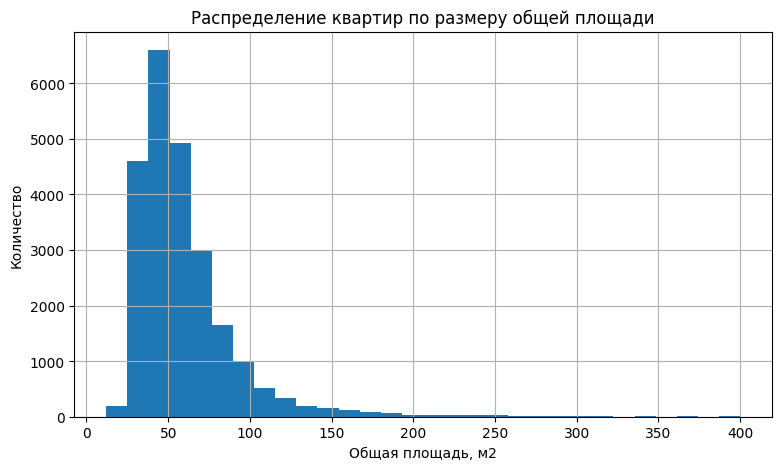

In [26]:
# описание данных в `total_area` с помощью гистограммы
data.plot(
    kind='hist',
    y='total_area',
    bins=30,
    ylabel='Количество',
    xlabel='Общая площадь, м2',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(12, 400),
    title='Распределение квартир по размеру общей площади'
) 
plt.show()

Есть выбросы, превышающие **Q3 + 1.5 IQR = 112.5 м2**. Возможно их общие площади указаны ошибочно. 

Сравним медианные цены квадратного метра: квартир с общей площадью до **300 м2** с квартирами большей площади.

In [27]:
# расчет медианной цены 1 м2 квартир площадью до 300 м2 
display(
    Markdown(
        f'Медианная цена 1 м2 квартир до 300 м2 = '
        f'**{data.query("total_area <= 300")["price_meter"].median()}**')
)

# расчет медианной цены 1 м2 квартир площадью более 300 м2 
display(
    Markdown(
        f'Медианная цена 1 м2 квартир более 300 м2 = '
        f'**{data.query("total_area > 300")["price_meter"].median()}**')
)

Медианная цена 1 м2 квартир до 300 м2 = **94997.755**

Медианная цена 1 м2 квартир более 300 м2 = **126924.9**

<div style="border:solid gray 1px; padding: 20px">

**Выводы**
1. Плошадь 75% квартир до 70 м2
2. Цены "больших" квартир не выглядят ошибочными и могут использоваться в дальнейшем исследовании
3. Строка с выбивающимся значением общей площади = 900 м2 удалена

#### Жилая площадь

Проанализируем значения жилой площади из столбца `living_area`

In [28]:
# числовое описание данных в `living_area`
data['living_area'].describe()

count   23698.00
mean       34.56
std        22.22
min         2.00
25%        19.00
50%        30.00
75%        42.11
max       409.00
Name: living_area, dtype: float64

Проверим редкие маленькие значения жилой площади. Например, с долей менее 10% от общей площади

In [29]:
# запись в переменную `data_filtered` отфильтрованного датафрейма
data_filtered = data.query('living_area / total_area < 0.1')

# вывод переменной data_filtered на экран
display(data_filtered)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
3242,7,4440000.00,41.00,2017-07-02,1,2.70,17,3.00,17,True,...,NaN,216,Санкт-Петербург,1.76,108292.68,6,7,2017,последний,13.00
13915,20,6350000.00,52.00,2018-02-06,2,3.00,6,2.00,2,True,...,1012.00,91,Санкт-Петербург,1.76,122115.38,1,2,2018,другой,7.00
21758,0,2330000.00,23.00,2018-01-01,0,2.70,24,2.00,22,True,...,NaN,66,поселок Мурино,2.15,101304.35,0,1,2018,другой,NaN
21943,15,6100000.00,77.60,2019-02-28,4,2.50,9,5.40,1,True,...,NaN,33,Санкт-Петербург,1.76,78608.25,3,2,2019,первый,11.00
23574,14,64990000.00,139.00,2015-11-24,3,3.00,8,3.00,8,True,...,100.00,280,Санкт-Петербург,1.76,467553.96,1,11,2015,последний,6.00


Вероятно отсутствует вторая цифра в размере жилой площади. Логичное исправление невозможно. Удалим эти строки из таблицы.

In [30]:
# удаление строк с маленькой жилой площадью
data.drop(data_filtered.index, inplace=True)

Покажем на гистограмме распределение квартир по размеру жилой площади

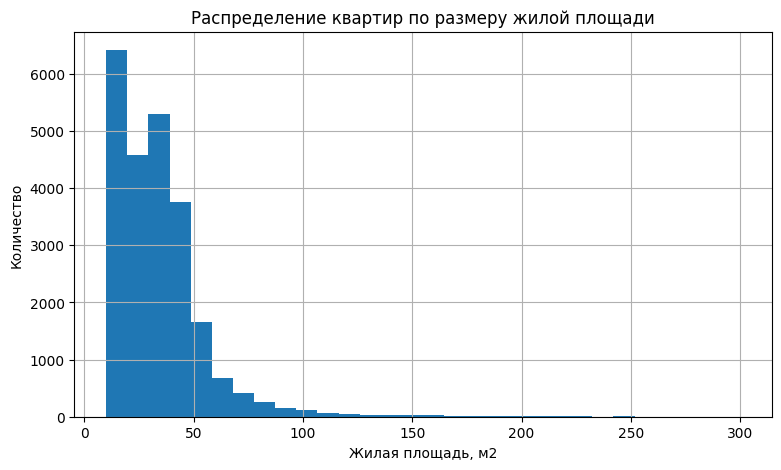

In [31]:
# описание данных в `living_area` с помощью гистограммы
data.plot(
    kind='hist',
    y='living_area',
    bins=30,
    ylabel='Количество',
    xlabel='Жилая площадь, м2',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(10, 300),
    title='Распределение квартир по размеру жилой площади'
) 
plt.show()

Есть выбросы, превышающие **Q3 + 1.5 IQR = 77.5 м2**. Возможно жилые площади этих квартир указаны ошибочно. 
 

Сравним медианные цены квадратного метра: квартир с жилой площадью до **100 м2** с квартирами большей площади.

In [32]:
# расчет медианной цены 1 м2 квартир с жилой площадью до 100 м2 
display(
    Markdown(
        f'Медианная цена 1 м2 квартир с жилой площадью до 100 м2 = '
        f'**{data.query("living_area <= 100")["price_meter"].median()}**')
)

# расчет медианной цены 1 м2 квартир с жилой площадью более 100 м2 
display(
    Markdown(
        f'Медианная цена 1 м2 квартир с жилой площадью более 100 м2 = '
        f'**{data.query("living_area > 100")["price_meter"].median()}**')
)

Медианная цена 1 м2 квартир с жилой площадью до 100 м2 = **94791.67**

Медианная цена 1 м2 квартир с жилой площадью более 100 м2 = **117215.95**

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Жилая площадь 75% квартир до 43 м2
2. Цены квартир с "большой" жилой площадью не выглядят ошибочными и могут использоваться в дальнейшем исследовании
3. Аномально маленькие значения в жилой площади квартир исключены
4. 8,03% пропущенных значений не повлияют на результаты исследования


#### Площадь кухни

Проанализируем значения площади кухни из столбца `kitchen_area`

In [33]:
# расчет доли пропущенных значений в столбце `kitchen_area`
display(
    Markdown(
        f'Доля пропущенных значений площади кухни = '
        f'**{data["kitchen_area"].isna().sum() / len(data["kitchen_area"]):.2%}**')
)

Доля пропущенных значений площади кухни = **9.61%**

In [34]:
# числовое описание данных в `kitchen_area`
data['kitchen_area'].describe()

count   21416.00
mean       10.56
std         5.87
min         1.30
25%         7.00
50%         9.10
75%        12.00
max       107.00
Name: kitchen_area, dtype: float64

Проверим маленькие значения площади кухни. Например, с площадью кухни менее 2 м2.

In [35]:
# запись в переменную `data_filtered` отфильтрованного датафрейма 
data_filtered = data.query('kitchen_area < 2')

#вывод переменной `data_filtered` на экран
display(data_filtered)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
20217,7,4250000.00,28.50,2019-05-01,1,2.80,14,19.50,10,True,...,NaN,<NA>,Санкт-Петербург,1.76,149122.81,2,5,2019,другой,13.00


Удалим строку с площадью кухни менее 2 м2.

In [36]:
# удаление строк с площадью кухни менее 2 м2
data.drop(data_filtered.index, inplace=True)

Покажем на гистограмме распределение квартир по площади кухни

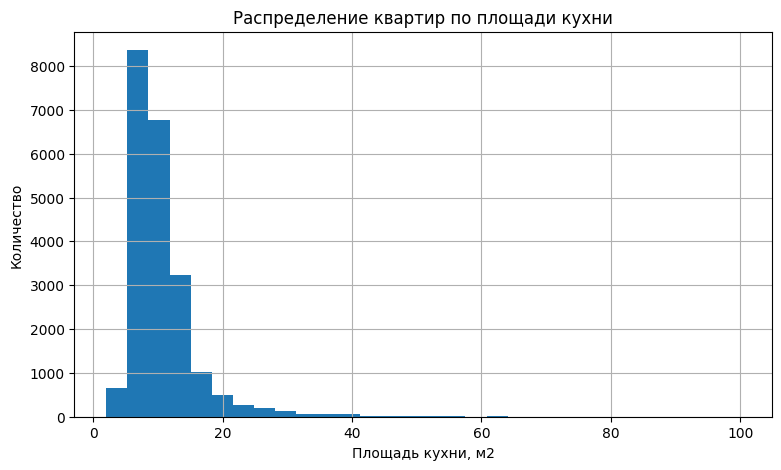

In [37]:
# описание данных в `kitchen_area` с помощью гистограммы
data.plot(
    kind='hist',
    y='kitchen_area',
    bins=30,
    ylabel='Количество',
    xlabel='Площадь кухни, м2',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(2, 100),
    title='Распределение квартир по площади кухни'
)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Плошадь кухни 75% квартир до 12 м2
2. Аномальные значения в площади кухни исключены
3. 9,61% пропущенных значений не окажут сущеcтвенного влияния на результаты исследования


#### Стоимость объекта недвижимости

Проанализируем значения стоимости из столбца `last_price`

In [38]:
# числовое описание данных в `last_price`
data['last_price'].describe()

count       23692.00
mean      6522020.27
std      10545169.55
min         12190.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
max     763000000.00
Name: last_price, dtype: float64

Проверим квартиры с низкой стоимостью. Например, менее 100 тыс

In [39]:
# запись в переменную `data_filtered` отфильтрованного датафрейма 
data_filtered = data.query('last_price < 100000')

#вывод переменной `data_filtered` на экран
display(data_filtered)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
8793,7,12190.00,109.00,2019-03-20,2,2.75,25,32.00,25,True,...,NaN,8,Санкт-Петербург,1.76,111.83,2,3,2019,последний,9.00


Учитывая общую плошадь квартиры, вероятно в стоимости не зватает трёх нулей. Исправим стоимость и цену квадратного метра.

In [40]:
# запись нового значения стоимости в столбец `last_price`
data.loc[data_filtered.index, 'last_price'] = 12190000

# расчет и запись новой цены квадратного метра в столбец `price_meter`
data.loc[data_filtered.index, 'price_meter'] = \
(
    data.loc[data_filtered.index, 'last_price'] / 
    data.loc[data_filtered.index, 'total_area']
)

Проверим квартиры с аномально высокой стоимостью более 400 млн. И сравним со стоимостью квартир с такой же общей площадью 400 м2.

In [41]:
# вывод списка квартир со стоимостью более 700 млн или общей площадью 400 м2
data.query('last_price > 400000000 or total_area == 400')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
5873,0,38000000.00,400.00,2019-03-15,7,3.60,3,227.64,1,True,...,NaN,<NA>,Санкт-Петербург,1.76,95000.00,4,3,2019,первый,5.00
12971,19,763000000.00,400.00,2017-09-30,7,2.70,10,250.00,10,True,...,756.00,33,Санкт-Петербург,1.76,1907500.00,5,9,2017,последний,4.00
14706,15,401300000.00,401.00,2016-02-20,5,2.70,9,204.00,9,False,...,478.00,393,Санкт-Петербург,1.76,1000748.13,5,2,2016,последний,2.00
15151,15,88000000.00,400.00,2019-03-27,9,2.50,2,250.00,1,True,...,578.00,<NA>,Санкт-Петербург,1.76,220000.00,2,3,2019,первый,3.00


Вероятно в стоимости квартир **763 млн** и **401,3 млн** есть лишний ноль. Исправим стоимость и цену квадратного метра.

In [42]:
# сохранение индексов исправляемых строк в переменную `index_price`
index_price = data.query('last_price > 400000000').index

# запись новых значений `last_price` и `price_meter`
data.loc[index_price, ['last_price','price_meter']] *= 0.1

Покажем на гистограмме распределение квартир по стоимости

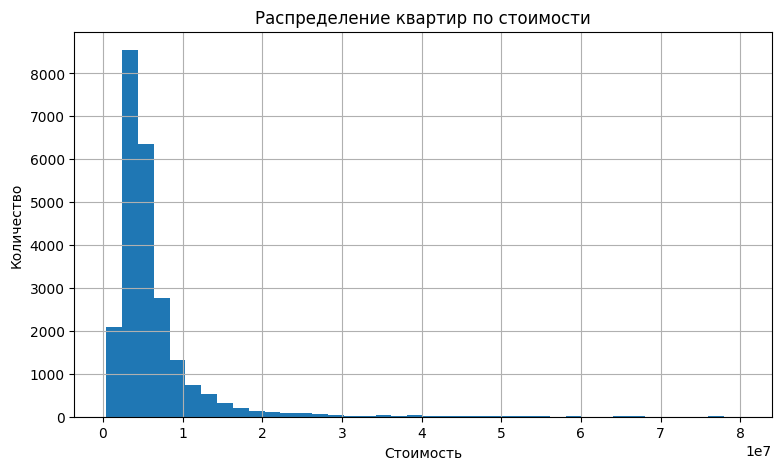

In [43]:
# описание данных в `last_price` с помощью гистограммы c ограничением до 100 млн
data.plot(
    kind='hist',
    y='last_price',
    bins=40,
    ylabel='Количество',
    xlabel='Стоимость',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(400000, 80000000),
    title='Распределение квартир по стоимости'
)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Стоимость 75% квартир до 6,8 млн
2. Аномальные значения стоимости исправлены

#### Количество комнат

Проанализируем значения количества комнат из столбца `rooms`

In [44]:
# числовое описание данных в `last_price`
data['rooms'].describe()

count   23692.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

Прверим квартиры с нулевым количеством комнат.

In [45]:
# запись в переменную `data_filtered` датафрейма c нулевым количеством комнат  
data_filtered = data.query('rooms == 0')

# вывод количества строк c нулевым количеством комнат
display(
    Markdown(
        f'У **{data_filtered["rooms"].count()}** квартир нулевое количество комнат.')
)

У **196** квартир нулевое количество комнат.

Вероятно это ошибка при выгрузке - вместо отсутствующих значений записались нули.

Исправим количество комнат на медианное количество комнат у квартир с подобной общей площадью:

- посчитаем медианное значение общей площади квартир с количеством комнат = 0
- отфильтруем квартиры по полученной общей площади и получим их медиану количества комнат
- исправим нулевые значения комнат

In [46]:
# запись в переменную `median_total_area` медианы общей площади с нулевым количеством комнат
median_total_area = data.query('rooms == 0')['total_area'].median()

#запись количества комнат вместо нулевых значений в `rooms`       
data.loc[data_filtered.index, 'rooms'] = (
    data
    .query('@median_total_area+1 > total_area > @median_total_area-1 and rooms != 0')
    .groupby('total_area')['rooms']
    .transform(lambda x: round(x.median()))
)

Покажем на гистограмме распределение квартир по количеству комнат

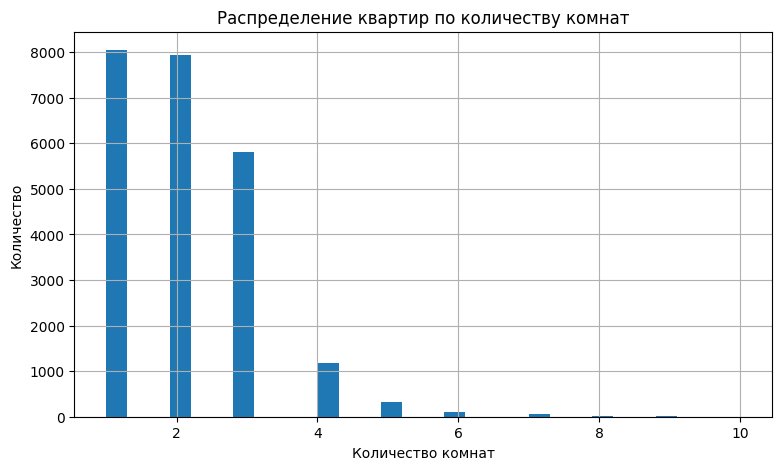

In [47]:
### описание данных в `rooms` с помощью гистограммы 
data.plot(
    kind='hist',
    y='rooms',
    bins=30,
    ylabel='Количество',
    xlabel='Количество комнат',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(1, 10),
    title='Распределение квартир по количеству комнат'
)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. У 50% квартир одна или две комнаты.
2. Судя по гистограмме количество однушек и двушек примерно равное - примерно по четверти каждых  
3. Аномальные нулевые значения количества комнат исправлены

#### Высота потолков

Проанализируем значения высоты потолков из столбца `ceiling_height`

In [48]:
# числовое описание данных в `ceiling_height`
data['ceiling_height'].describe()

count   23692.00
mean        2.73
std         1.00
min         1.00
25%         2.55
50%         2.70
75%         2.70
max       100.00
Name: ceiling_height, dtype: float64

Прверим квартиры с высотой потолков от 10 метров.

In [49]:
# запись в переменную `data_filtered` датафрейма c `ceiling_height` >= 10
data_filtered = data.query('ceiling_height >= 10')

# вывод 5-ти строк отсортированного датафрейма в переменной`data_filtered`
display(
    data_filtered
    .sort_values(by='ceiling_height', ascending=False)
    .head()
)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
22869,0,15000000.00,25.00,2018-07-25,1.00,100.00,5,14.00,5,True,...,30.00,19,Санкт-Петербург,1.76,600000.00,2,7,2018,последний,8.00
3148,14,2900000.00,75.00,2018-11-12,3.00,32.00,3,53.00,2,True,...,NaN,<NA>,Волхов,1.58,38666.67,0,11,2018,другой,NaN
22336,19,9999000.00,92.40,2019-04-05,2.00,32.00,6,55.50,5,False,...,511.00,<NA>,Санкт-Петербург,1.76,108214.29,4,4,2019,другой,4.00
21377,19,4900000.00,42.00,2017-04-18,1.00,27.50,24,37.70,19,False,...,NaN,61,Санкт-Петербург,1.76,116666.67,1,4,2017,другой,10.00
5807,17,8150000.00,80.00,2019-01-09,2.00,27.00,36,41.00,13,True,...,80.00,38,Санкт-Петербург,1.76,101875.00,2,1,2019,другой,20.00


Вероятно двузначные и трехзначное значения высоты потолков - ошибка при вводе информации. Запишем новые значения, разделив текущие на 10

In [50]:
# деление на 10 и перезапись отфильтрованных значений высоты потолка в столбце `ceiling_height`
data.loc[data_filtered.index, 'ceiling_height'] /= 10

Прверим квартиры с высотой потолков менее 2 метров.

In [51]:
# запись в переменную `data_filtered` датафрейма c `ceiling_height` < 2
data_filtered = data.query('ceiling_height < 2')

# вывод 5-ти строк отсортированного датафрейма в переменной`data_filtered`
display(
    data_filtered
    .sort_values(by='ceiling_height')
    .head()
)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
22590,16,6000000.00,55.00,2018-10-31,2.00,1.00,12,32.40,7,True,...,289.00,13,Санкт-Петербург,1.76,109090.91,2,10,2018,другой,14.00
22309,20,5300000.00,45.00,2017-09-30,1.00,1.03,16,15.50,15,True,...,450.00,136,Санкт-Петербург,1.76,117777.78,5,9,2017,другой,12.00
5712,5,1500000.00,42.80,2017-08-14,2.00,1.20,2,27.50,1,True,...,NaN,248,поселок Мга,1.50,35046.73,0,8,2017,первый,NaN
15061,19,5600000.00,56.40,2018-05-11,2.00,1.40,14,32.40,5,True,...,NaN,315,Санкт-Петербург,1.76,99290.78,4,5,2018,другой,14.00
16934,5,4100000.00,40.00,2017-10-17,1.00,1.75,37,17.40,5,True,...,80.00,71,Санкт-Петербург,1.76,102500.00,1,10,2017,другой,20.00


Исправим высоту потолков менее 2 метров медианными значениями высоты потолков в каждом населенном пункте

In [52]:
# запись в переменную `data_filtered` датафрейма с высотой потолка < 2 м
data_filtered = data.query('ceiling_height < 2')

# исправление значений в столбце ceiling_height медианными значениями из столбца `locality_name_dupless`
data.loc[data_filtered.index, 'ceiling_height'] = \
(
    data
    .groupby('locality_name_dupless')['ceiling_height']
    .transform('median')
)

Покажем на гистограмме распределение квартир по высоте потолков

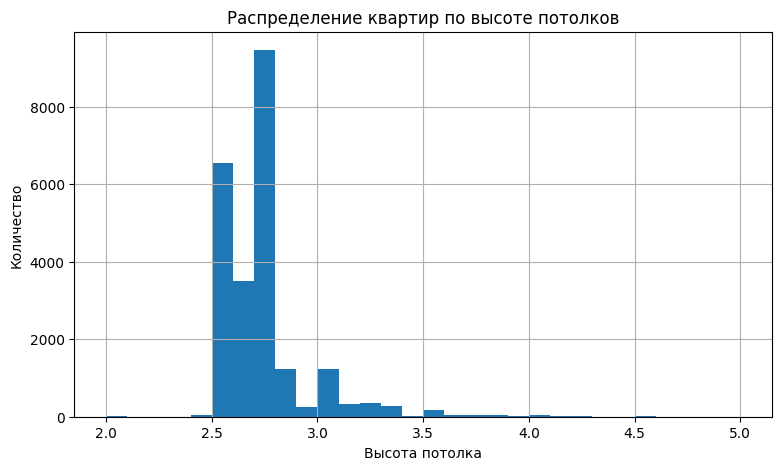

In [53]:
# описание данных в `ceiling_height` с помощью гистограммы 
data.plot(
    kind='hist',
    y='ceiling_height',
    bins=30,
    ylabel='Количество',
    xlabel='Высота потолка',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(2, 5),
    title='Распределение квартир по высоте потолков'
)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. У 75% квартир высота потолков 2,7 метра.
2. Ошибочные значения высоты потолков исправлены  

#### Тип этажа квартиры

Проанализируем значения типов этажа из столбца `floor_type`.

In [54]:
# количество квартир по типам  в `floor_type`
data['floor_type'].value_counts()

floor_type
другой       17360
последний     3444
первый        2888
Name: count, dtype: int64

In [55]:
# доля каждого типа в `floor_type`
(
    data["floor_type"]
    .value_counts(normalize=True)
    .apply(lambda x: f"{x:.2%}")
)

floor_type
другой       73.27%
последний    14.54%
первый       12.19%
Name: proportion, dtype: object

Покажем на круговой диаграмме распределение квартир по типу этажа

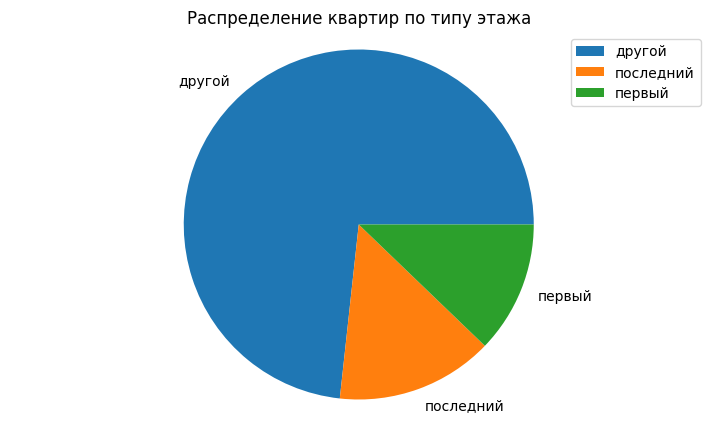

In [56]:
# описание данных в `floor_type` с помощью круговой диаграммы 
(
    data['floor_type']
    .value_counts()
    .plot(
        kind='pie',
        grid=True,
        legend=True,
        figsize=(9,5),title='Распределение квартир по типу этажа')
)
plt.axis('equal')
plt.axis('off')  
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. 73% квартир находится между первым и последним этажами.
2. Количество квартир на первом и последнем этажах примерно одинаковое.

#### Общее количество этажей в доме

Проанализируем этажность домов из столбца `floors_total`.

In [57]:
# числовое описание данных в `floors_total`
data['floors_total'].describe()

count   23692.00
mean       10.67
std         6.60
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

Проверим максимальную этажность дома. Например, выведем строки с этажностью более 40.

In [58]:
# запись в переменную `data_filtered` датафрейма c `floors_total` > 40
data_filtered = data.query('floors_total > 40')

# вывод отсортированного датафрейма в переменной`data_filtered`
display(data_filtered)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_dupless,ratio_area_living,price_meter,day_public,month_public,year_public,floor_type,cityCenters_km
2253,12,3800000.00,45.50,2018-06-28,2.00,2.88,60,27.40,4,True,...,614.00,166,Кронштадт,1.65,83516.48,3,6,2018,другой,49.00
16731,9,3978000.00,40.00,2018-09-24,1.00,2.65,52,10.50,18,True,...,NaN,45,Санкт-Петербург,1.76,99450.00,0,9,2018,другой,13.00


Удалим строки с редкими и выбивающиеся значениями этажности **более 40**.

In [59]:
# удаление строк в которых `floors_total` > 40
data.drop(data_filtered.index, inplace=True)

Покажем на гистограмме распределение квартир по этажности дома

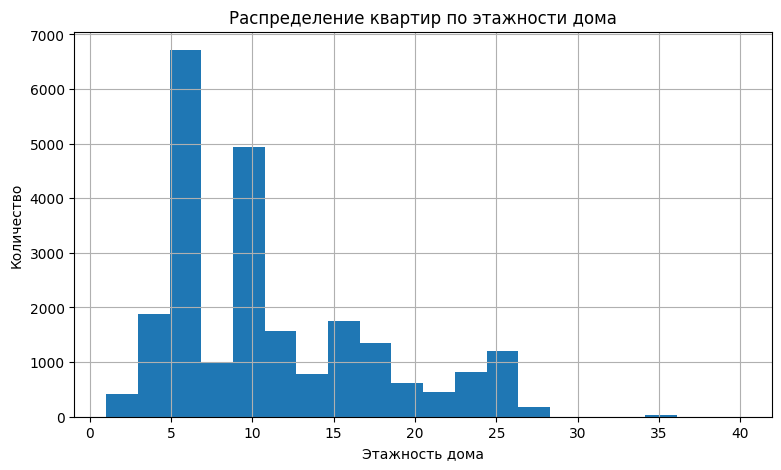

In [60]:
# описание данных в `floor_type` с помощью гистограммы 
data.plot(
    kind='hist',
    y='floors_total',
    bins=20,
    ylabel='Количество',
    xlabel='Этажность дома',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(1, 40),
    title='Распределение квартир по этажности дома'
) 
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Преобладают квартиры в 5-ти этажных и 9-ти этажных домах.
2. Исключены квартиры с выбивающиеся значениями этажности более 40 

#### Расстояние до центра города в метрах

Проанализируем значения из столбца `cityCenters_nearest`.

In [61]:
# расчет доли пропущенных значений в столбце `cityCenters_nearest`
display(
    Markdown(
    f'Доля пропущенных значений в расстоянии до центра города: '
    f'**{data["cityCenters_nearest"].isna().sum() / len(data["cityCenters_nearest"]):.2%}**')
)

Доля пропущенных значений в расстоянии до центра города: **23.29%**

In [62]:
# числовое описание данных в `floors_total`
data['cityCenters_nearest'].describe()

count   18172.00
mean    14190.93
std      8605.72
min       181.00
25%      9238.00
50%     13101.00
75%     16293.00
max     65968.00
Name: cityCenters_nearest, dtype: float64

Ранее мы рассчитывали и округляли удаленность квартиры от центра в километрах. И для дальнейшего анализа нам нужны квартиры с удаленностью **от 1 км**. Проверим, есть ли квартиры с меньшей удаленностью.

In [63]:
# запись в переменную `data_filtered` датафрейма c `cityCenters_km` < 1
data_filtered = data.query("cityCenters_km < 1")

# вывод количество строк с `cityCenters_km` < 1
display(Markdown(
    f'**{data_filtered["cityCenters_km"].count()}**'
    f' квартир с удаленностью от центра менее 1 км')
)

**27** квартир с удаленностью от центра менее 1 км

Исправим удаленнсть от центра таких квартир:
- в метрах на 500
- в километрах на 1

In [64]:
# перезапись значений столбца `cityCenters_nearest` в строках где `cityCenters_km` < 1 км
data.loc[data_filtered.index, 'cityCenters_nearest'] = 500

# перезапись значений столбца `cityCenters_km` в строках где `cityCenters_km` < 1 км
data.loc[data_filtered.index, 'cityCenters_km'] = 1

Покажем на гистограмме распределение квартир по удаленности от центра в метрах

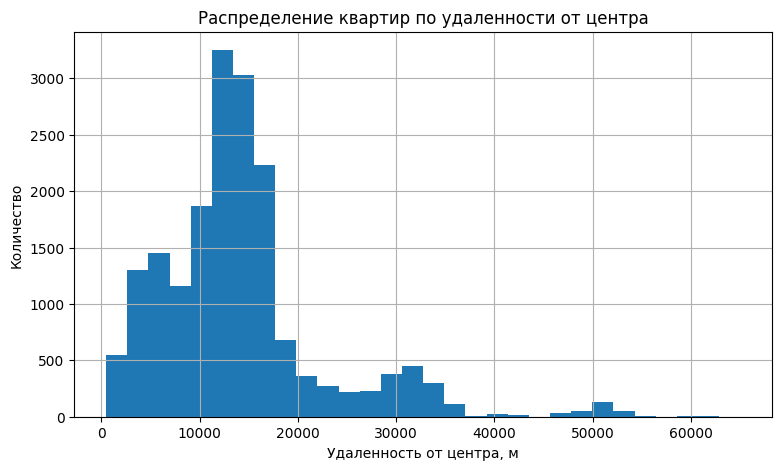

In [65]:
# описание данных в `cityCenters_nearest` с помощью гистограммы 
data.plot(
    kind='hist',
    y='cityCenters_nearest',
    bins=30,
    ylabel='Количество',
    xlabel='Удаленность от центра, м',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(500, 65000),
    title='Распределение квартир по удаленности от центра'
) 
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. 75% квартир находятся в радиусе 16293 м от центра города
2. У квартир, удаленных от центра менее 500 м:
   - исправлена удаленность в метрах на 500
   - исправлена удаленность в километрах на 1
4. 23.29% пропущенных значений могут повлиять на результаты исследования

#### Расстояние до ближайшего парка

Проанализируем значения из столбца `parks_nearest`.

In [66]:
# расчет доли пропущенных значений в столбце `parks_nearest`
display(
    Markdown(
        f'Доля пропущенных значений в расстоянии до ближайшего парка: '
        f'**{data["parks_nearest"].isna().sum() / len(data["parks_nearest"]):.2%}**')
)

Доля пропущенных значений в расстоянии до ближайшего парка: **65.91%**

In [67]:
# числовое описание данных в `parks_nearest`
data['parks_nearest'].describe()

count   8075.00
mean     490.76
std      342.38
min        1.00
25%      288.00
50%      455.00
75%      612.00
max     3190.00
Name: parks_nearest, dtype: float64

Покажем на гистограмме распределение квартир по удаленности от парка в метрах

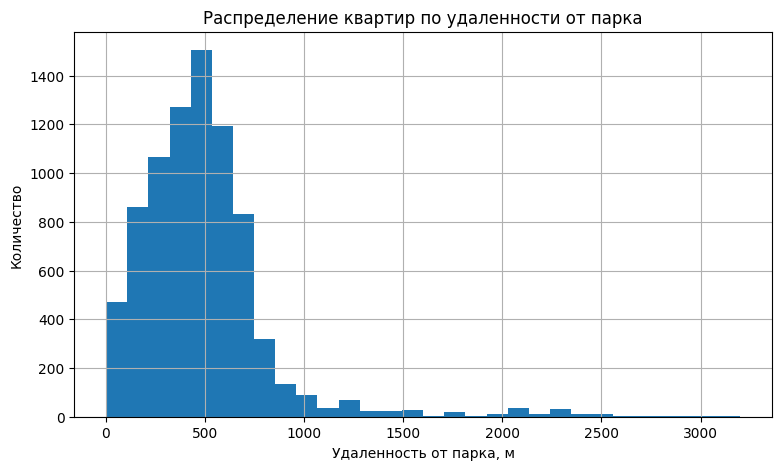

In [68]:
# описание данных в `parks_nearest` с помощью гистограммы 
data.plot(
    kind='hist',
    y='parks_nearest',
    bins=30,
    ylabel='Количество',
    xlabel='Удаленность от парка, м',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(1, 3200),
    title='Распределение квартир по удаленности от парка'
) 
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. 75% квартир находятся в радиусе 612 м от парка
4. 65.91% вероятно повлияют на результаты исследования

<a id="how_fast"></a>
### Как быстро продавались квартиры?

Для ответа на вопрос проанализируем количество дней размещения каждого объявления в столбце `days_exposition`.

Оценим числовое распределение данных в столбце.

In [69]:
# числовое описание данных в `days_exposition`
data['days_exposition'].describe()

count   20510.00
mean      180.91
std       219.76
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: Float64

<a id="hist_day"></a>
Построим гистограмму распределение квартир по времени размещения объвления.

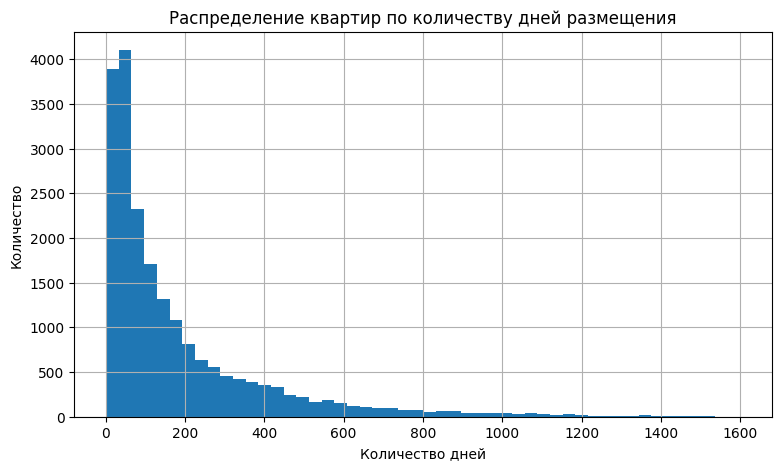

In [70]:
# описание данных в `days_exposition` с помощью гистограммы 
data.plot(
    kind='hist',
    y='days_exposition',
    bins=50,
    ylabel='Количество',
    xlabel='Количество дней',
    grid=True,
    legend=False,
    figsize=(9,5),
    range=(1, 1600),
    title='Распределение квартир по количеству дней размещения'
) 
plt.show()

Посчитаем отдельно среднее и медианное значения количества дней

In [71]:
# вывод среднего значения в столбце `days_exposition`
display(
    Markdown(
        f'Среднее количество дней размещения объявления: '
        f'**{data["days_exposition"].mean():.0f}**')
)

# вывод медианного значения в столбце `days_exposition`
display(
    Markdown(
        f'Медианное количество дней размещения объявления: '
        f'**{data["days_exposition"].median():.0f}**')
)

Среднее количество дней размещения объявления: **181**

Медианное количество дней размещения объявления: **95**

<a id="boxplot"></a>
Для визуального подтверждения характеристик распределения построим диаграмму размаха.

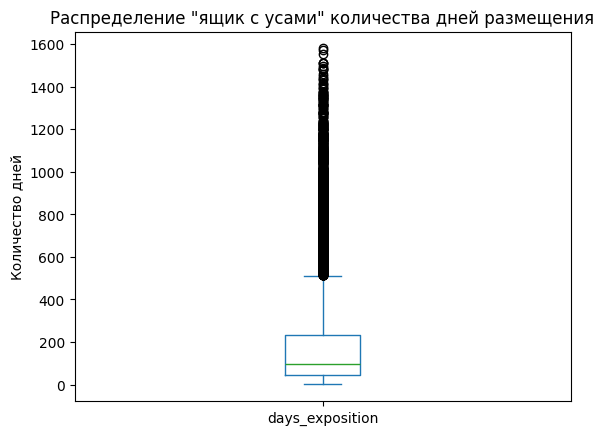

In [72]:
# вывод диаграммы boxplot для значений столбца `days_exposition`
(
    data["days_exposition"]
    .plot(
        kind='box',
        ylabel='Количество дней',
    )
)
plt.title('Распределение "ящик с усами" количества дней размещения')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Характеристики распределения объявлений по количеству дней размещения:
   - Q1 = 45
   - Q3 = 232
   - Интерквартильный размах (IQR) = 232-45 = 187
2. Обычно продажа квартиры происходит в течение **95** дней после размещения объявления. Это медианное значение.
3. Быстрыми продажами можно считать те, которые завершились в течение **45** дней размещения объявления (до первого квартиля)
4. Необычно долгими продажами можно считать те, которые произошли после **513** (Q3+1,5*IQR) дней размещения
5. Среднее значение **181** почти в раза больше Медианы **95**:
   - распределение данных имеет длинный хвост выбросов в сторону объявлений с большим сроком размещения (см. [выбросы на диаграмме размаха](#boxplot). Эти значения значительно превышают медиану и не влияют на нее сильно. Но увеличивают среднее значение, делая его больше медианы.
   - большое количество объявлений с маленьким сроком размещения (см. [гистограмму](#hist_day)) сдвигает медианное значение в сторону меньших значений
   

<a id="factors"></a>
### Анализ факторов, влияющих на стоимость квартиры

Проанализируем зависимость значений в столбце `last_price` от значений в следующих слобцах:
- `total_area` - общая площадь
- `living_area` - жилая площадь
- `kitchen_area` - площадь кухни
- `rooms` - количество комнат
- `floor_type` - тип этажа квартиры
- `day_pulic` - дня недели размещения
- `month_pulic` - месяца размещения
- `year_pulic` - года размещения

#### Зависимость стоимости квартиры от общей площади

Построим график зависимости и рассчитаем коэффициент корреляции Пирсона. Исключим на графике редкие значения общей площади более 400 м2.

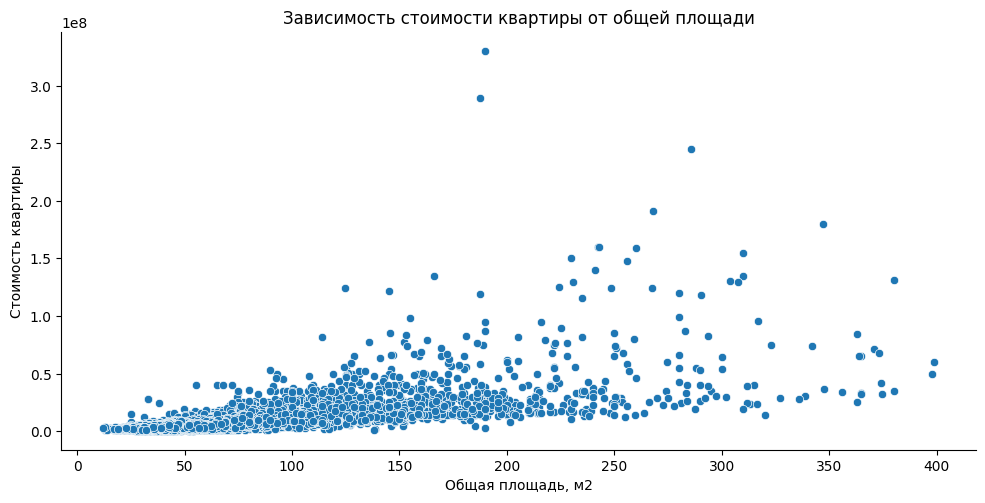

Коэффициент корреляции: **0.71**

In [73]:
# запись в переменную `data_filtered` отфильтрованного датафрейма
data_filtered = data.query('total_area < 400')

# вывод графика зависимости между значениями `last_price` и `total_area` без группировки
sns.pairplot(
    data_filtered,
    kind='scatter',
    x_vars='total_area',
    y_vars='last_price',
    aspect= 2,
    height=5,
)

plt.xlabel('Общая площадь, м2')
plt.ylabel('Стоимость квартиры')
plt.title('Зависимость стоимости квартиры от общей площади')
plt.show()

# вывод коэффициента корреляции между значениями в `last_price` и `total_area`
display(
    Markdown(
        f'Коэффициент корреляции: '
        f'**{data["last_price"].corr(data["total_area"]):.2f}**')
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. График и коэффициент корреляции указывают на умеренно сильную положительную связь между общей площадью и стоимостью квартиры.
2. Более крупные объекты стремятся к более высоким ценам, а меньшие объекты - к более низким ценам.
3. Характерные выбросы на графике указывют на наличие и других факторов, влияющих на стоимость квартиры.

#### Зависимость стоимости квартиры от жилой площади

Построим график зависимости и рассчитаем коэффициент корреляции Пирсона. Исключим на графике редкие значения общей площади более 200 м2.

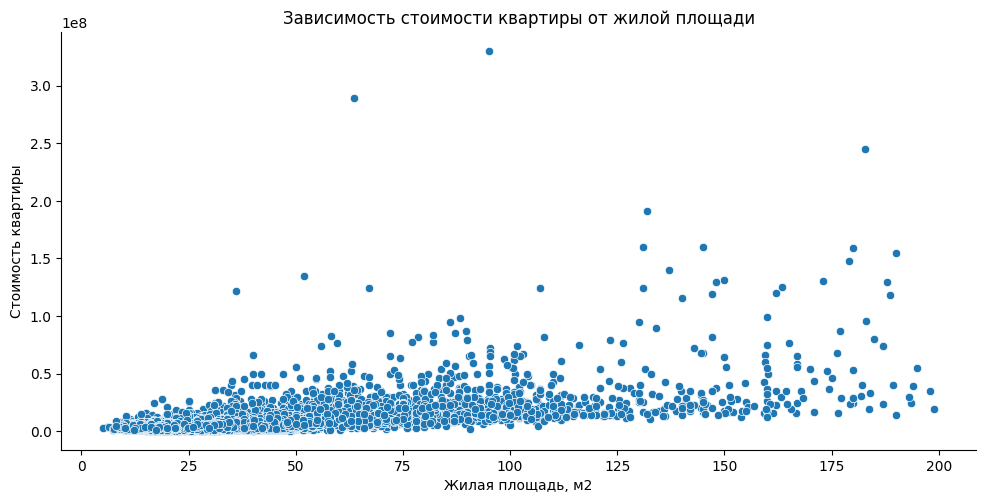

Коэффициент корреляции: **0.64**

In [74]:
# запись в переменную `data_filtered` отфильтрованного датафрейма
data_filtered = data.query('living_area < 200')

# вывод графика зависимости между значениями в `last_price` и `living_area`
sns.pairplot(
    data_filtered,
    kind='scatter',
    x_vars='living_area',
    y_vars='last_price',
    aspect= 2,
    height=5,
)

plt.xlabel('Жилая площадь, м2')
plt.ylabel('Стоимость квартиры')
plt.title('Зависимость стоимости квартиры от жилой площади')
plt.show()

# вывод коэффициента корреляции между значениями в `last_price` и `total_area`
display(
    Markdown(
        f"Коэффициент корреляции: "
        f"**{data['last_price'].corr(data['living_area']):.2f}**")
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. График и коэффициент корреляции указывают на умеренно сильную положительную связь между жилой площадью и стоимостью квартиры.
2. Изменение жилой площади влияет на стоимость квартиры меньше чем изменение общей площади.
3. Выбросы на графике указывют на наличие и других факторов, влияющих на стоимость квартиры.

#### Зависимость стоимости квартиры от площади кухни

Построим график зависимости и рассчитаем коэффициент корреляции Пирсона. Исключим на графике редкие значения общей площади более 60 м2.

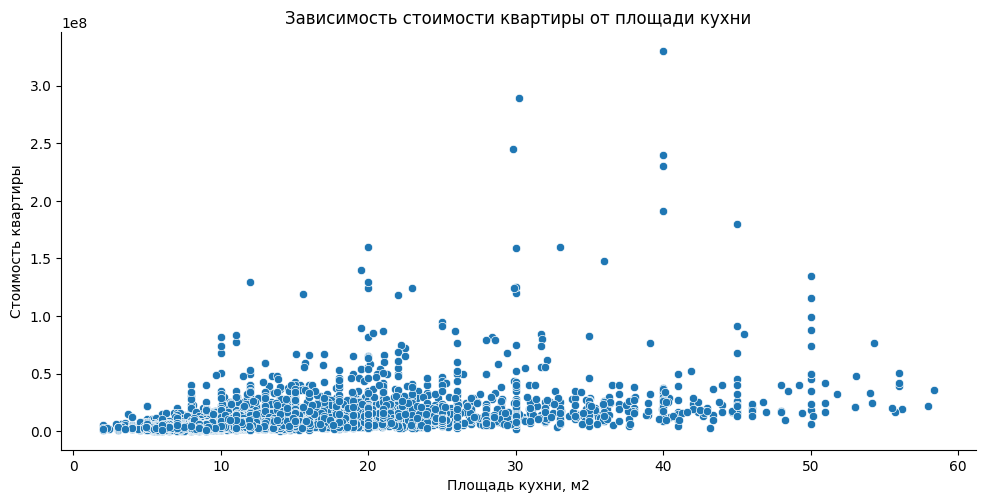

Коэффициент корреляции: **0.53**

In [75]:
# запись в переменную `data_filtered` отфильтрованного датафрейма
data_filtered = data.query('kitchen_area < 60')

# вывод графика зависимости между значениями в `last_price` и `kitchen_area`
sns.pairplot(
    data_filtered,
    kind='scatter',
    x_vars='kitchen_area',
    y_vars='last_price',
    aspect= 2,
    height=5,
)

plt.xlabel('Площадь кухни, м2')
plt.ylabel('Стоимость квартиры')
plt.title('Зависимость стоимости квартиры от площади кухни')
plt.show()
# вывод коэффициента корреляции между значениями в `last_price` и `kitchen_area`
display(
    Markdown(
        f"Коэффициент корреляции: "
        f"**{data['last_price'].corr(data['kitchen_area']):.2f}**")
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. График и коэффициент корреляции указывают на умеренную положительную связь между площадью кухни и стоимостью квартиры.
2. Изменение площади кухни влияет на стоимость квартиры меньше чем изменение общей и жилой площади.
3. Выбросы на графике указывют на влияние других факторов на стоимость квартиры.

#### Зависимость стоимости квартиры от количества комнат

Построим график зависимости и рассчитаем коэффициент корреляции Пирсона.

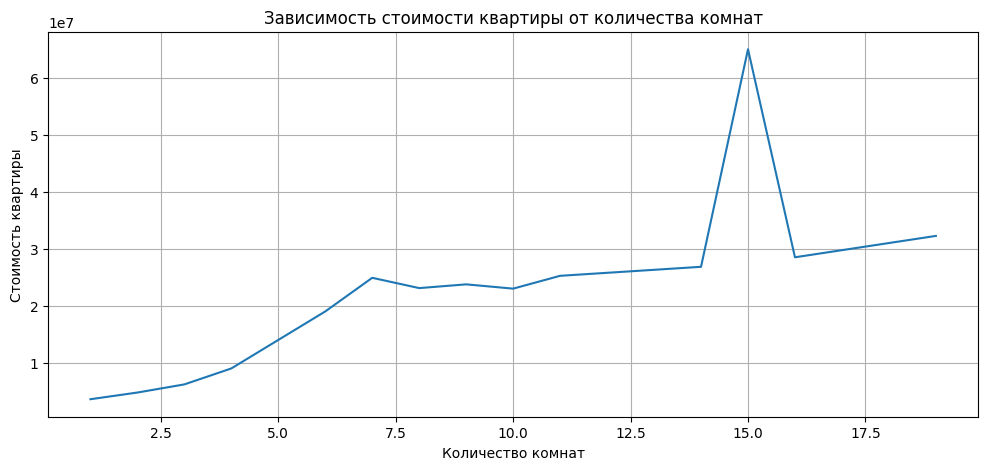

Коэффициент корреляции: **0.41**

In [76]:
# вывод графика зависимости между значениями в `last_price` и `rooms`
(
    data
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(
        grid=True, 
        figsize=(12, 5),
        ylabel='Стоимость квартиры',
        xlabel='Количество комнат',
        legend=False,
        title='Зависимость стоимости квартиры от количества комнат')
) 
plt.show()

# вывод коэффициента корреляции между значениями в `last_price` и `rooms`
display(
    Markdown(
        f"Коэффициент корреляции: "
        f"**{data['last_price'].corr(data['rooms']):.2f}**")
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. График и коэффициент корреляции указывают на умеренную положительную связь между количеством комнат и стоимостью квартиры.
2. Изменение количества комнат влияет на стоимость квартиры в меньшей степени чем характеристики площади квартиры.

#### Зависимость стоимости квартиры от типа этажа

Построим график зависимости.

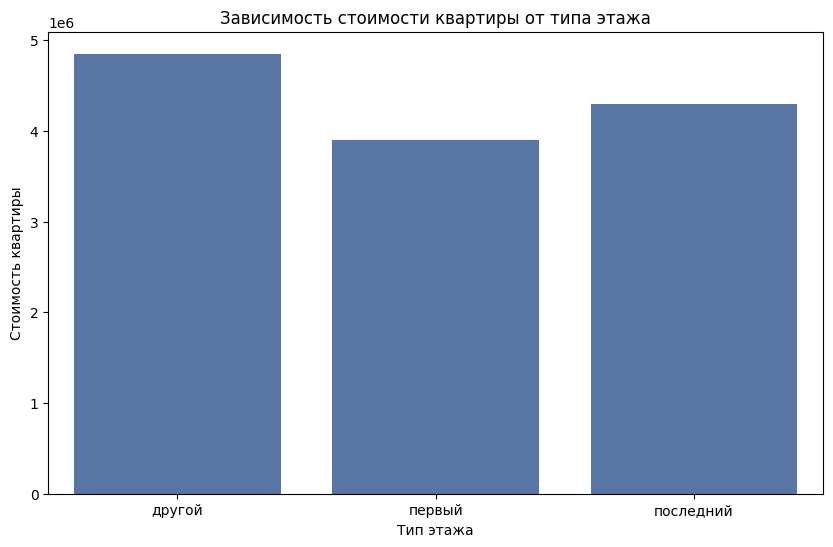

In [77]:
# создание сводной таблицы для получения медианных значений `last_price`
pivot_table = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')

# преобразование индекса в столбец
pivot_table.reset_index(inplace=True)
# вывод графика зависимости между значениями в `last_price` и `floor_type`
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pivot_table,
    x='floor_type',
    y='last_price',
    color='#4c72b0'
)

plt.xlabel('Тип этажа')
plt.ylabel('Стоимость квартиры')
plt.title('Зависимость стоимости квартиры от типа этажа')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Квартиры на первом этаже имеют самую низкую стоимость.
2. Квартиры на последнем этаже дороже квартир на первом этаже
3. "Другие" квартиры дороже, чем на первом и последнем этажах

#### Зависимость стоимости квартиры от дня недели размещения объявления

Построим график зависимости.

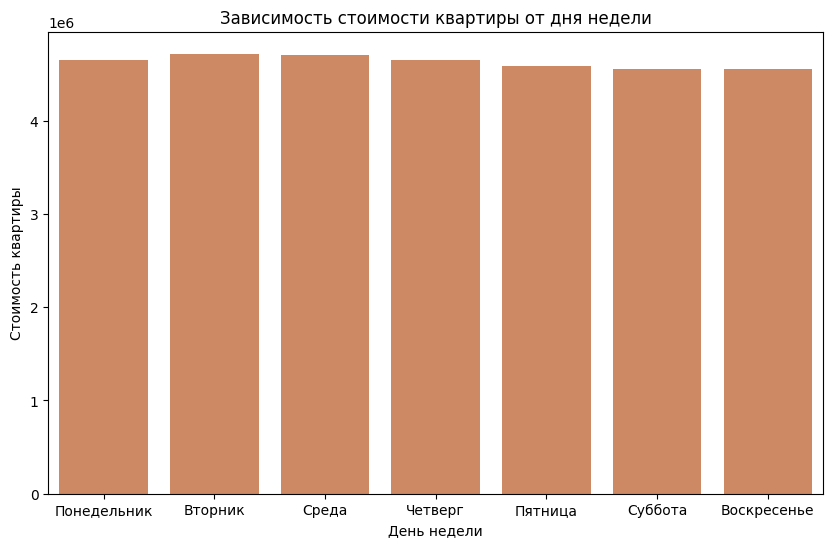

In [78]:
# создание сводной таблицы для получения медианных значений `last_price`
pivot_table = data.pivot_table(index='day_public', values='last_price', aggfunc='median')

# создание словаря для замены номеров дней недели на названия
day_dict = {
    0: 'Понедельник', 
    1: 'Вторник', 
    2: 'Среда', 
    3: 'Четверг', 
    4: 'Пятница', 
    5: 'Суббота', 
    6: 'Воскресенье'
}

# замена номеров дней недели на названия в индексе сводной таблицы
pivot_table.index = pivot_table.index.map(day_dict)

# преобразование индекса в столбец
pivot_table.reset_index(inplace=True)

# вывод графика зависимости между значениями в `last_price` и `day_public`
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pivot_table,
    x='day_public',
    y='last_price',
    color='#dd8452'
)

plt.xlabel('День недели')
plt.ylabel('Стоимость квартиры')
plt.title('Зависимость стоимости квартиры от дня недели')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. Квартиры, размещенные в конце недели продавались по немного сниженной цене. Возможно, продавцы или агенты стараются привлечь больше клиентов и закрыть сделки до конца недели.

#### Зависимость стоимости квартиры от месяца размещения объявления

Построим график зависимости.

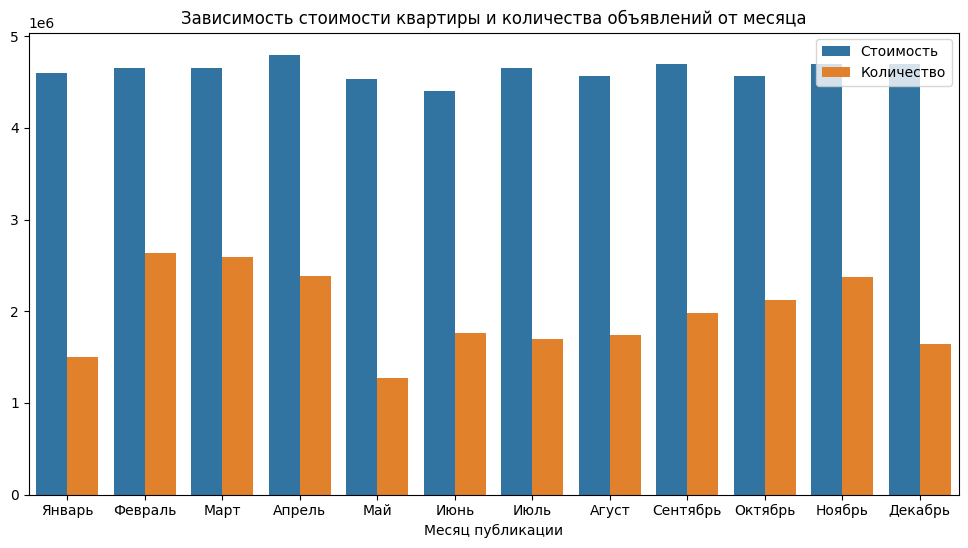

In [79]:
# создание сводной таблицы для стоимости и количества
pivot_table = data.pivot_table(index='month_public', values='last_price', aggfunc=['median', 'count'])

# переименование столбцов
pivot_table.columns = ['Стоимость', 'Количество']

# выравнивание порядка величин
pivot_table['Количество'] *= 1000

# создание словаря для замены номеров месяца на названия
month_dict = {
    1: 'Январь', 
    2: 'Февраль', 
    3: 'Март', 
    4: 'Апрель', 
    5: 'Май', 
    6: 'Июнь', 
    7: 'Июль',
    8: 'Агуст',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь',
}

# замена номеров месяца на названия в индексе сводной таблицы
pivot_table.index = pivot_table.index.map(month_dict)

# преобразование индекса в столбец
pivot_table.reset_index(inplace=True)

# преобразование `pivot_table` для отображения
melted_table = pivot_table.melt(id_vars='month_public', var_name='метрика', value_name='значение')

# вывод графика зависимости между значениями в `last_price` и `month_public`
plt.figure(figsize=(12, 6))
sns.barplot(x='month_public', y='значение', hue='метрика', data=melted_table)
plt.xlabel('Месяц публикации')
plt.ylabel('')
plt.title('Зависимость стоимости квартиры и количества объявлений от месяца')
plt.legend(title='', loc='upper right')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. Сезонное снижение цен следует за сезонным снижением спроса на недвижимость и уменьшением количества объвлений о продаже. Например с середины мая до середины августа спрос и предложение держатся на низком уровне, что способствует снижение стоимости.

#### Зависимость стоимости квартиры от года размещения объявления

Построим график зависимости.

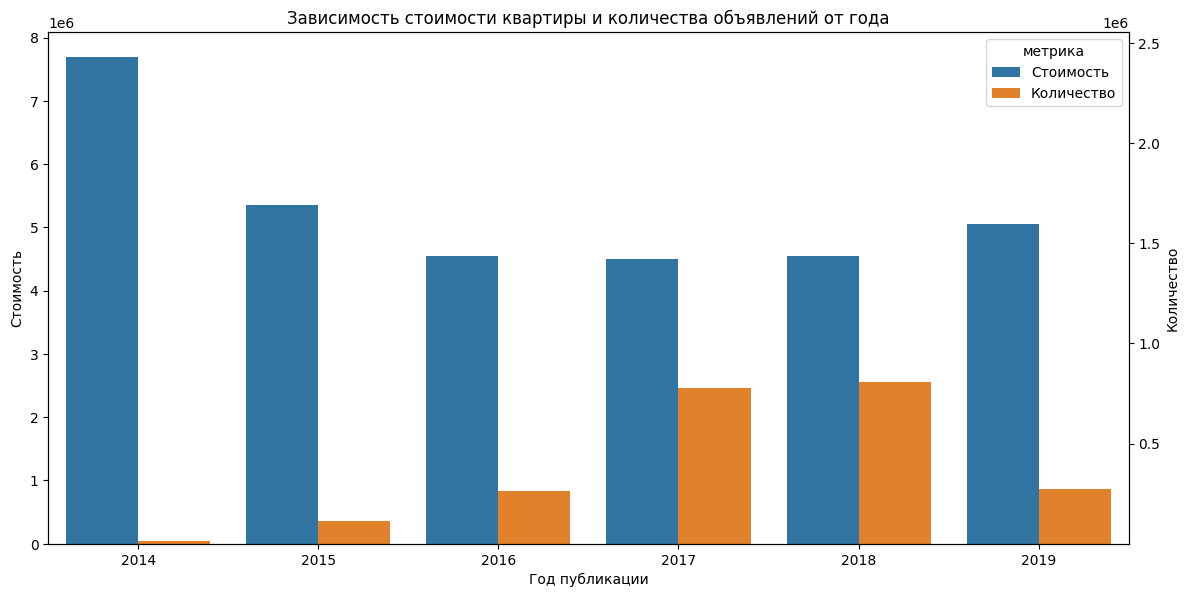

In [80]:
# создание сводной таблицы для стоимости и количества
pivot_table = data.pivot_table(index='year_public', values='last_price', aggfunc=['median', 'count'])

# переименование столбцов
pivot_table.columns = ['Стоимость', 'Количество']

# выравнивание порядка величин
pivot_table['Количество'] *= 300

# преобразование индекса в столбец
pivot_table.reset_index(inplace=True)

# преобразование pivot_table для отображения
melted_table = pivot_table.melt(id_vars='year_public', var_name='метрика', value_name='значение')

# вывод графика зависимости между значениями в last_price и month_public
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='year_public', y='значение', hue='метрика', data=melted_table, ax=ax1)

ax1.set_xlabel('Год публикации')
ax1.set_ylabel('Стоимость')

# создаем вторую ось y
ax2 = ax1.twinx()

# задаем метки для второй оси y
ax2.set_ylabel('Количество')

# задаем лимиты для второй оси y
ax2.set_ylim(1, melted_table.query('метрика == "Количество"')['значение'].max())

fig.tight_layout()  # чтобы оси не перекрывались
plt.title('Зависимость стоимости квартиры и количества объявлений от года')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. Периоды экономического роста и стабильности приводят к росту цен и увеличению количества предложений( 2017-2018 гг.)
2. Во время кризисов может уменьшаться количество предложений и снижаться стоимость квартир (2014-2015 гг.)

<a id="localities"></a>
### Анализ населенных пунктов

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Используем значения населенных пунктов из столбца `locality_name_dupless`, содержащим названия без дубликатов.

In [81]:
# запись сводной талицы в переменную `locality_price`
locality_price = \
(
    data.pivot_table(
        index='locality_name_dupless', 
        values='price_meter', 
        aggfunc=['count', 'mean'])
)
# переименование названия столбцов
locality_price.columns = ['Количество объвлений', 'Средняя цена']

# переименование индекса, сортировка по убыванию, вывод 10 первых строк
(
    locality_price
    .rename_axis('Населенный пункт')
    .sort_values(by='Количество объвлений', ascending=False)
    .head(10)
)

,Количество объвлений,Средняя цена
Населенный пункт,,
Санкт-Петербург,15714,114645.78
поселок Мурино,555,85653.61
поселок Шушары,440,78677.36
Всеволожск,398,68654.47
Пушкин,369,103125.82
Колпино,338,75424.58
поселок Парголово,327,90175.91
Гатчина,307,68746.15
деревня Кудрово,299,92473.55


Населённые пункты с самой высокой/низкой стоимостью квадратного метра.

In [82]:
# запись максимальной цены в переменную`max_price`
max_price = data['price_meter'].max()

# вывод значения `locality_name_dupless` с максимальной ценой
display(
    Markdown(
        f'В городе **"{data.query("price_meter == @max_price")["locality_name_dupless"].values[0]}"**'
        f' самая высокая стоимость квадратного метра **{max_price}**')
)

# запись минимальной цены в переменную`min_price`
min_price = data['price_meter'].min()

# вывод значения `locality_name_dupless` с минимальной ценой
display(
    Markdown(
        f'В **"{data.query("price_meter == @min_price")["locality_name_dupless"].values[0]}"**'
        f' самая низкая стоимость квадратного метра **{min_price}**')
)

В городе **"Санкт-Петербург"** самая высокая стоимость квадратного метра **1736842.11**

В **"поселок станции Свирь"** самая низкая стоимость квадратного метра **7962.96**

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 

1. Больше всего объвлений о продаже евартир в городе Санкт-Петербург - **15714**
2. В Санкт-Петербурге и самая высокая стоимость квадратного метра - **1 736 842** руб.
3. Самая низкая стоимость квадратного метра в поселке при станции Свирь - **7 962** руб.

<a id="center_distance"></a>
### Зависимость стоимости квартир от расстояния до центра города

Построим график зависимости и рассчитаем коэффициент корреляции Пирсона для квартир в городе Санкт-Петербург

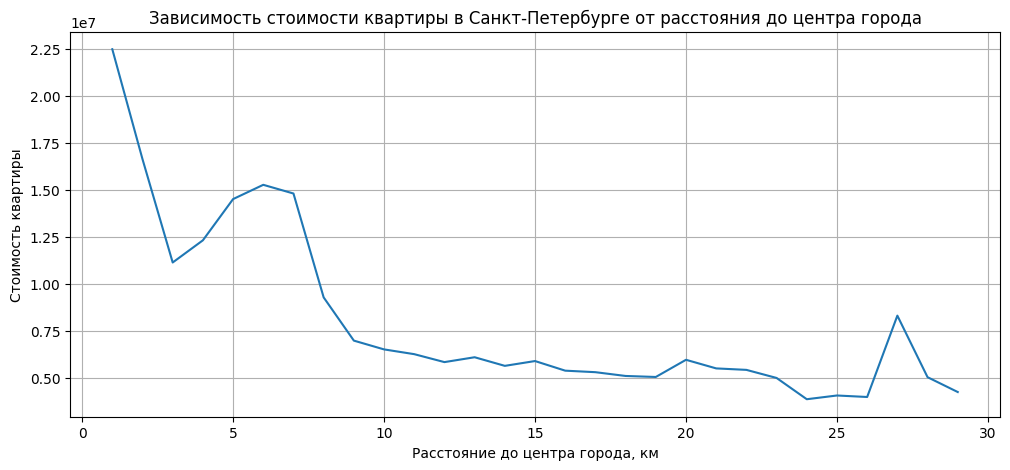

Коэффициент корреляции: **-0.31**

In [83]:
# запись таблицы квартир Санкт-петербурга в `data_spb` 
data_spb = data.query('locality_name == "Санкт-Петербург"')

# расчет сводной таблицы и построение графика` 
(
    data_spb
    .pivot_table(index='cityCenters_km', values='last_price')
    .plot(
        grid=True, 
        figsize=(12, 5),
        ylabel='Стоимость квартиры',
        xlabel='Расстояние до центра города, км',
        legend=False,
        title='Зависимость стоимости квартиры в Санкт-Петербурге от расстояния до центра города')
)   
plt.show()

# вывод коэффициента корреляции между значениями в `last_price` и `cityCenters_km`
display(
    Markdown(
        f"Коэффициент корреляции: "
        f"**{data_spb['last_price'].corr(data_spb['cityCenters_km']):.2f}**")
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 

1. График и коэффициент корреляции указывают на слабую отрицательную связь между удаленнлстью квартир в Санкт-Петербурге от центра города и их стоимостью. 
2. Удаление квартиры от центра не всегда приводит к уменьшению ее стоимости. Например на графике удаленность между ~ 2,5 - 7 км.
3. Наличие парков, водоемов, инфраструктуры может снизить негативное влияние удаленности от центра

<a id="research_results"></a>
## Итоги исследования

Результаты исследования рыночной стоимости объектов недвижимости могут быть использованы для построения автоматизированной системы отслеживания аномалий и мошеннической деятельности.

**Установлено**:


1. Редкие и аномальные значения:
   - большие значения обшей площади квартир
   - редкие маленькие значения жилой площади
   - маленькие значения площади кухни
   - аномально высокие и низкие значения стоимости
   - "нулевые" значения количества комнат
   - двузначные и трехзначное значения высоты потолков
   - большие значения этажности дома
2. **Обычно** продажа квартиры происходит в течение **95** дней после размещения объявления. **Быстрая** продажа квартиры происходит в течение **45** дней после размещения объявления. Необычно **долгая** продажа - после **513** дней размещения.
3. Больше всего на стоимоость квартиры влияет **общая и жилая** площади квартиры. Увеличение этих площадей приводит к увеличению стоимости квартиры. Расположение на первом или последнем этаже может снижать стоимость квартиры.
5. Cамая **высокая** стоимость квадратного метра в Санкт-Петербурге - **1 736 842** руб. А самая **низкая** в поселке при станции Свирь - **7 962** руб.
6. Удаление квартиры от центра Санкт-Петербурга не всегда приводит к уменьшению ее стоимости. Наличие парков, водоемов, инфраструктуры может снизить негативное влияние удаленности от центра на стоимость квартиры.
   
**Рекомендации**:

1. Повысить квачество и процент собираемости данных из геосервисов. Например, расстояние до центра города, аэропорта и других объектов.
2. Провести дополнительное исследование про влияние на стоимость: типа квартиры, удаленности от парков, водоемов и аэропортов.
3. Выявить возможные причины появления пропусков. Исключить технические ошибки и снизить влияние человеческого фактора за счет автоматического контроля корректности заполнения ключевой информации

[Вернуться в начало](#intro)